In [1]:
from exp.expdata import GenExAdapter
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from exp.evaluate.jsindy import evaluate_jmodel

In [50]:
noise = 0.1
dt_train = 2.0
t1=50.

expdata = GenExAdapter(
    system="vdp", t0=0., t1=t1, 
    noise=noise, n_train=100, 
    n_colloc=500, seed=1234,
    ic_std=0.02,
    )

In [51]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(100,)

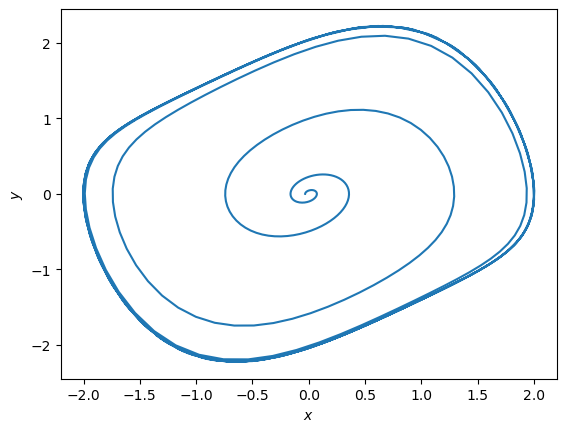

In [52]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

# Learn Model

In [53]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


## Let jsindy handle 2nd order

In [54]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(STLSQ(threshold = 0.1,alpha = 0.01))
optimizer = AnnealedAlternatingActiveSetLMSolver(
    beta_reg=1e-3,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

In [55]:
from importlib import reload
import jsindy.optim.optimizers
reload(jsindy.optim.optimizers)
from jsindy.optim.optimizers import AnnealedAlternatingActiveSetLMSolver

In [56]:
model.fit(expdata.t_train, expdata.x_train[:, :1], expdata.t_colloc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.0130747, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Solving for data_weight = 1.0, colloc_weight = 4000.0 beta_reg = 0.004


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.52, gradnorm = 83.29, alpha = 4.167, improvement_ratio = 0.9999
Iteration 1, loss = 0.7309, gradnorm = 22.8, alpha = 3.472, improvement_ratio = 1.002
Iteration 2, loss = 0.6236, gradnorm = 4.665, alpha = 2.894, improvement_ratio = 1.001
Iteration 3, loss = 0.5977, gradnorm = 1.122, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.5873, gradnorm = 0.3799, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.5818, gradnorm = 0.1797, alpha = 1.674, improvement_ratio = 1.0
Iteration 56, loss = 0.5256, gradnorm = 4.629e-09, alpha = 0.0001533, improvement_ratio = inf
Solving for data_weight = 1.0, colloc_weight = 20000.0 beta_reg = 0.002


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.5286, gradnorm = 6.304, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.5285, gradnorm = 0.07827, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.5284, gradnorm = 0.02014, alpha = 2.894, improvement_ratio = 0.9999
Iteration 3, loss = 0.5284, gradnorm = 0.01085, alpha = 2.411, improvement_ratio = 0.9998
Iteration 4, loss = 0.5284, gradnorm = 0.007962, alpha = 2.009, improvement_ratio = 0.9998
Iteration 5, loss = 0.5284, gradnorm = 0.006496, alpha = 1.674, improvement_ratio = 0.9998
Iteration 53, loss = 0.528, gradnorm = 4.312e-09, alpha = 0.3916, improvement_ratio = 655.0
Solving for data_weight = 1.0, colloc_weight = 100000.0 beta_reg = 0.001


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.529, gradnorm = 6.48, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.529, gradnorm = 0.02353, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.529, gradnorm = 0.006484, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.5289, gradnorm = 0.004936, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.5289, gradnorm = 0.004257, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.5289, gradnorm = 0.003836, alpha = 1.674, improvement_ratio = 1.0
Iteration 53, loss = 0.5287, gradnorm = 7.689e-09, alpha = 0.002414, improvement_ratio = 4.628
Model after smooth warm start
(x)'' = -0.022 1 + -1.058 x + 0.471 (x') + 0.021 x^2 + -0.013 x (x') + -0.009 (x')^2 + 0.012 x^3 + -0.236 x^2 (x') + 0.059 x (x')^2 + -0.080 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized


In [57]:
model.residuals.colloc_residual(model.z,model.theta)

Array([-2.85616339e-07,  5.24919978e-07,  2.19232780e-07,  3.66617452e-07,
        9.01198686e-07,  1.26182331e-06,  1.35127317e-06,  1.38672085e-06,
        1.44892413e-06,  1.47403926e-06,  1.46008047e-06,  1.48662578e-06,
        1.59698716e-06,  1.75994657e-06,  1.92164733e-06,  2.03496144e-06,
        2.05605859e-06,  1.97020501e-06,  1.82118853e-06,  1.66583937e-06,
        1.48810491e-06,  1.19866472e-06,  7.37324321e-07,  1.45696047e-07,
       -4.72681406e-07, -1.03013322e-06, -1.48276697e-06, -1.82351285e-06,
       -2.07647293e-06, -2.28111198e-06, -2.46342109e-06, -2.62447290e-06,
       -2.75455690e-06, -2.84744027e-06, -2.90353220e-06, -2.93251037e-06,
       -2.95187483e-06, -2.96905566e-06, -2.96649882e-06, -2.92457798e-06,
       -2.86482542e-06, -2.84857222e-06, -2.91807646e-06, -3.05287780e-06,
       -3.19199243e-06, -3.27880721e-06, -3.27883410e-06, -3.18656336e-06,
       -3.03386522e-06, -2.86324071e-06, -2.66802059e-06, -2.38141971e-06,
       -1.95335519e-06, -

In [58]:
x_pred = model.predict_state(expdata.t_true)
xdot_pred = model.traj_model.derivative(expdata.t_true,model.z,diff_order = 1)

x_true = expdata.x_true
model.print()

(x)'' = -0.985 x + 0.360 (x') + -0.349 x^2 (x')


In [59]:
expdata.print()

x' = 1 x'
x'' = -1 x + 0.5 x' + -0.5 x^2 x'


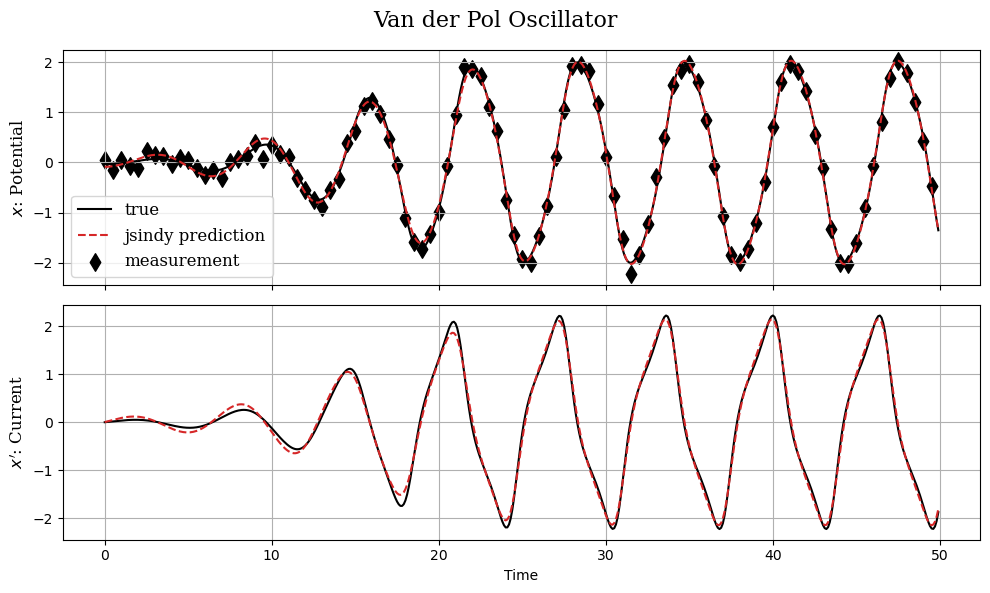

In [60]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Potential", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, xdot_pred[:,1], label='prediction', linestyle='--', c='tab:red')
# ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$x'$: Current", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Van der Pol Oscillator", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

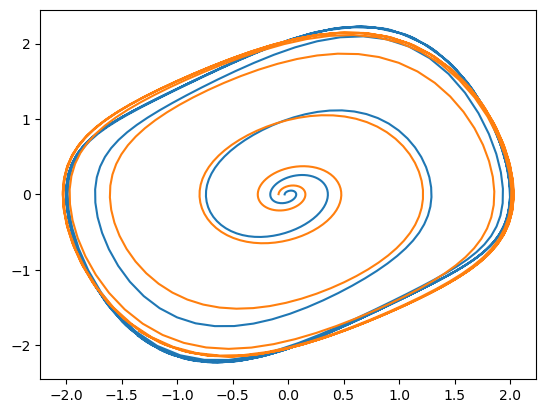

In [61]:
plt.plot(x_true[:,0],x_true[:,1])
plt.plot(x_pred[:,0],xdot_pred[:,0])